In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/psix/')
import psix

In [2]:
psix_object = psix.Psix()
psix_object.read_psix_object()

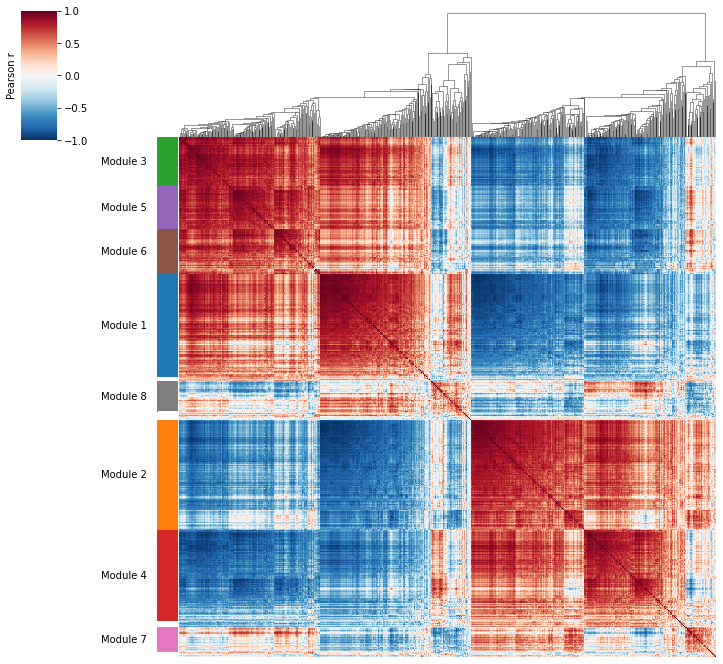

In [6]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/utils')
import psix_functions as pr


sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/analysis_psix/utils/')
from misc_utils import *

from scipy.special import logit, expit
import hotspot

background_psi = psix_object.adata.uns['neighbors_psi'].T

psix_results = psix_object.psix_results
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index


bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

In [49]:
norm_tpm = pd.read_csv('preprocess/scone_norm_tpm.tab', sep='\t', index_col=0)

In [51]:
discard = [x for x in norm_tpm.index if ((x[:3] in ['mt-', 'Gm0', 'Gm1', 'Gm2', 'Gm3', 'Gm4', 'Gm5', 
                                'Gm6', 'Gm7', 'Gm8', 'Gm9', 'Mir']) or (x[-3:] in ['Rik', '-ps']) or (x [-4:-1] == '-ps'))]
discard += ['EGFP'] + []

In [54]:
(norm_tpm.loc['Olig1'] > 0.1).sum()

344

In [55]:

glia = norm_tpm.columns[(norm_tpm.loc['Hepacam'] >= 1) | (norm_tpm.loc['Ednrb'] >= 1)  | (norm_tpm.loc['Olig1'] >= 1) | (norm_tpm.loc['Ramp1'] >= 1) | (norm_tpm.loc['Aldh1l1'] >= 1)]
neurogenesis_cells = [x for x in norm_tpm.columns if x not in glia]


In [56]:
len(neurogenesis_cells)

1067

In [57]:
psix_object.adata.uns['psi'].index & pd.Index(neurogenesis_cells)

Index(['SRR7408400', 'SRR7408401', 'SRR7408404', 'SRR7408413', 'SRR7408414',
       'SRR7408418', 'SRR7408422', 'SRR7408424', 'SRR7408426', 'SRR7408427',
       ...
       'SRR7410086', 'SRR7410088', 'SRR7410089', 'SRR7410090', 'SRR7410091',
       'SRR7410092', 'SRR7410093', 'SRR7410094', 'SRR7410096', 'SRR7410097'],
      dtype='object', length=1036)

In [65]:
from sklearn.decomposition import PCA

norm_tpm_neuro = norm_tpm[neurogenesis_cells]

tiklova_high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) > 2]
tiklova_fano = (norm_tpm_neuro.loc[tiklova_high_expression].var(axis=1)/norm_tpm_neuro.loc[tiklova_high_expression].mean(axis=1)).sort_values()

pca_norm_tiklova = PCA(n_components=30)
# pca_norm_tiklova = pca_norm_tiklova.fit_transform(tiklova_norm.T)
pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[tiklova_fano.index[-500:]].T)


# pca_norm_tiklova = PCA(n_components=30)
# pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro[neurogenesis_cells].T)

tiklova_rd = pd.DataFrame()
for i in range(30):
    tiklova_rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

tiklova_rd.index = neurogenesis_cells

tiklova_rd.PC_2 = -tiklova_rd.PC_2

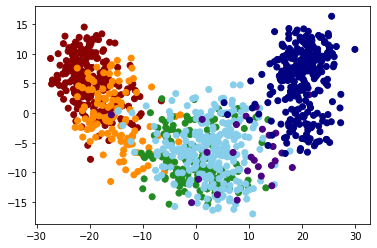

In [66]:
from sklearn.decomposition import PCA
meta = pd.read_csv('../scvi_runs/data/SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[neurogenesis_cells].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=colores)

Text(0, 0.5, 'PC2')

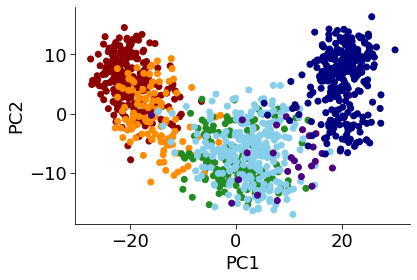

In [81]:

fig = plt.figure(figsize=(6, 4))
ax  = plt.subplot(1,1,1)
ax.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=colores)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(labelsize=18, length=5)
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)

In [83]:
tiklova_rd[['PC_1', 'PC_2', 'PC_3']].to_csv('preprocess/pc3_rd.tab.gz', sep='\t', index=True, header=True)
tiklova_rd[['PC_1', 'PC_2']].to_csv('preprocess/pc2_rd.tab.gz', sep='\t', index=True, header=True)

In [77]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/'
skipped_exons = pd.read_csv(data_dir + 'tiklova_extended/SE_counts.tab.gz', sep='\t', index_col=0)
tpm = pd.read_csv(data_dir + 'tiklova/rsem_gene_tpm.tab', sep='\t', index_col=0)
ci = pd.read_csv(data_dir + 'tiklova_extended/constitutive_introns.tab', sep=',', index_col=0)

In [75]:
os.mkdir('data/new_norm')

In [80]:
ci[neurogenesis_cells].to_csv('data/new_norm/constitutive_introns.tab.gz', sep='\t', index=True, header=True)
skipped_exons[neurogenesis_cells].to_csv('data/new_norm/sj_counts.tab.gz', sep='\t', index=True, header=True)
tpm[neurogenesis_cells].to_csv('data/new_norm/tpm.tab.gz', sep='\t', index=True, header=True)